# 这是什么东西?
在这次作业中，你已经写了很多代码来提供整个神经网络的功能。Dropout、批处理规范和2D卷积是计算机视觉中深度学习的主要部分。您还努力使代码更高效、更向量化。
不过，对于本作业的最后一部分，我们将离开您漂亮的代码库，转而迁移到两个流行的深度学习框架之一:在本例中，PyTorch(或者TensorFlow，如果您选择使用该记事本)。

### 什么是PyTorch?
PyTorch是一个在张量对象上执行动态计算图形的系统，其行为类似于numpy ndarray。它提供了一个强大的自动微分引擎，消除了手动反向传播的需要。
### 为什么?
* 我们的代码现在将运行在gpu !更快的训练。当使用像PyTorch或TensorFlow这样的框架时，您可以利用GPU的能力来构建自己的自定义神经网络架构，而不必直接编写CUDA代码(这超出了本类的范围)。
* 我们希望你能在你的项目中使用这些框架，这样你就能更有效地进行实验，而不是手工编写你想要使用的每个特性。
* 我们要你站在巨人的肩膀上!TensorFlow和PyTorch都是非常好的框架，它们可以让您的生活变得更加轻松，现在您已经了解了它们的核心，可以自由地使用它们了:)
* 我们希望你能接触到你可能在学术界或工业界遇到的那种深度学习代码。

### PyTorch版本
本笔记本假设您正在使用**PyTorch 1.0**。在以前的一些版本中(例如0.4之前)，张量必须包装在变量对象中才能在autograd中使用;然而，变量现在已经被弃用了。此外，1.0还将张量的数据类型与其设备分离，并使用数字类型的工厂来构造张量，而不是直接调用张量构造函数。

## How will I learn PyTorch?

贾斯汀·约翰逊做了一个很好的 [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch. 

你也可以找到详细的 [API doc](http://pytorch.org/docs/stable/index.html). 如果你有其他API文档没有解决的问题，可以使用[PyTorch forum](https://discuss.pytorch.org/) 是一个比StackOverflow更好的地方。


# 目录

这个作业有5个部分。您将在**三个不同的抽象级别**上学习PyTorch，这将帮助您更好地理解它并为最终项目做好准备。
1. 第一部分，准备工作:我们将使用CIFAR-10数据集。
2. 第二部分，基本的PyTorch: **抽象级别1**，我们将直接使用最低级别的PyTorch张量。
3. 第三部分，PyTorch模块API: **抽象级别2**，我们将使用' nn。模块定义任意的神经网络结构。
4. 第四部分，PyTorch序列API: **抽象级别3**，我们将使用' nn。非常方便地定义一个线性前馈网络。
5. 第五部分，CIFAR-10开放式挑战:请实现您自己的网络，在CIFAR-10上获得尽可能高的准确性。您可以使用任何层、优化器、超参数或其他高级特性进行试验。
以下是比较表:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# 第一部分准备
首先，我们加载CIFAR-10数据集。第一次执行时可能需要几分钟，但之后应该保持缓存。
在之前的作业中，我们必须编写自己的代码来下载CIFAR-10数据集，对其进行预处理，并在小批量中迭代;PyTorch为我们提供了方便的工具来自动化这个过程。

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [51]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


你有一个选项**使用GPU设置为真以下**。这个任务不需要使用GPU。注意，如果您的计算机没有启用CUDA， ' torch.cuda.is_available() '将返回False，本笔记本将退回到CPU模式。
全局变量' dtype '和' device '将在整个赋值过程中控制数据类型。

In [52]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# 第二部分Barebones PyTorch

PyTorch附带高级api来帮助我们方便地定义模型架构，我们将在本教程的第二部分中介绍。在本节中，我们将从barebone PyTorch元素开始，以便更好地理解autograd引擎。在此练习之后，您将更加欣赏高级模型API。
我们将从一个简单的全连接的ReLU网络开始，它有两个隐藏层，对CIFAR分类没有偏见。
该实现使用PyTorch张量上的操作计算正向传递，并使用PyTorch autograd计算梯度。理解每一行是很重要的，因为在示例之后您将编写一个更难的版本。
当我们创建一个带有`requires_grad=True`的PyTorch张量时，涉及到这个张量的运算将不仅仅是计算值;他们也将在后台建立一个计算图形，使我们可以很容易地通过图形反向传播来计算一些张量相对于下游损失的梯度。具体来说，如果x是一个带`x.requires_grad == True`然后在反向传播之后`x.grad`是另一个张量，它包含了x的梯度和最后的标量损失。

### PyTorch张量:Flatten函数
PyTorch张量在概念上类似于numpy数组:它是一个n维数字网格，与numpy PyTorch一样，它提供了许多函数来有效地操作张量。作为一个简单的例子，我们提供了一个“flatten”函数，它可以对图像数据进行整形，以便在全连接的神经网络中使用。
回想一下，图像数据通常存储在一个形状为N x C x H x W的张量中，其中:
* N是数据点的数量
* C是通道的数量
* H是中间feature map的高度，以像素为单位
* W是中间feature map的高度，以像素为单位

这是表示数据的正确方法当我们做二维卷积的时候，这需要对中间特征相互之间的空间关系的理解。然而，当我们使用完全连接的仿射层来处理图像时，我们希望每个数据点由单个向量表示——隔离数据的不同通道、行和列不再有用。因此，我们使用“flatten”操作将每个表示的“C x H x W”值折叠成一个长向量。下面的flatten函数首先从给定的一批数据中读取N、C、H和W的值，然后返回该数据的“视图”。“视图”类似于numpy的“重塑”方法:它将x的维度重塑为nx ??,在哪里? ?可以是任何值(在本例中，它是C x H x W，但是我们不需要明确地指定)。

In [53]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

在这里，我们定义了一个函数`two_layer_fc`，它对一批图像数据执行两层全连接ReLU网络的前向传递。在定义了向前传递之后，我们检查它是否崩溃，并通过在网络中运行零来生成正确形状的输出。

您不必在这里编写任何代码，但是阅读和理解实现是非常重要的。

In [54]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Three-Layer ConvNet

在这里，您将完成函数`three_layer_convnet`的实现，该函数将执行一个三层卷积网络的前向传递。像上面一样，我们可以通过在网络中传递zeros来立即测试我们的实现。该网络应具有以下架构:

1. 一个卷积层(带偏置)，带有' channel_1 '过滤器，每个过滤器的形状为' KW1 x KH1 '，填充0为2
2. ReLU非线性
3. 一个卷积层(带偏置)，带有' channel_2 '过滤器，每个过滤器的形状为' KW2 x KH2 '，填充0为1
4. ReLU非线性
5. 带偏见的全连接层，生成C类分数。

注意，在我们的全连接层之后，这里没有**softmax激活**:这是因为PyTorch的交叉熵损失为您执行了softmax激活，并且通过绑定该步骤使计算更有效。

**提示**:For convolutions: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d;注意卷积滤波器的形状!

In [55]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    scores=F.relu_(F.conv2d(x,conv_w1,conv_b1,padding=2))
    scores=F.relu_(F.conv2d(scores,conv_w2,conv_b2,padding=1))
    scores=F.linear(flatten(scores),fc_w.T,fc_b)
    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

在定义了上面的前向通道之后，运行以下单元来测试您的实现。
当你运行这个函数时，分数应该有形状(64,10)。

In [56]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
让我们写几个实用程序方法来初始化我们的模型的权重矩阵。
- `random_weight(shape)`使用kaim归一化方法初始化一个权张量。
- `zero_weight(shape)`用所有的0初始化一个权张量。用于实例化偏差参数。

`random_weight`函数使用的是kaim普通初始化方法，具体描述如下:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [57]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[ 0.0079,  0.4542,  0.8575,  0.4253,  0.3410],
        [ 0.0303,  0.7374, -1.3735, -0.4506, -0.1054],
        [-0.6689, -1.1883, -0.3662, -0.4428,  0.8126]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
在训练模型时，我们将使用以下功能来检查我们的模型在训练集或验证集上的准确性。
在检查精度时，我们不需要计算任何梯度;因此，在计算分数时，我们不需要PyTorch为我们构建计算图。为了防止构建一个图，我们在一个`torch.no_grad()`上下文管理器下确定计算范围。

In [58]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
我们现在可以建立一个基本的训练循环来训练我们的网络。我们将使用无动量的随机梯度下降法来训练模型。我们将使用`torch.cross_entropy`计算损失的交叉熵; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

训练循环以神经网络函数、初始化参数列表(在我们的示例中为‘[w1, w2]’)和学习率作为输入。

In [59]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
现在我们准备运行训练循环。我们需要为完全连接的权值“w1”和“w2”显式地分配张量。
每一小批CIFAR有64个例子，所以张量的形状是“[64,3,32,32]”。
压扁后的“x”形为“[64,3 * 32 * 32]”。这将是' w1 '的第一个维度的大小。
“w1”的第二个维度是隐藏层大小，这也是“w2”的第一个维度。
最后，网络的输出是一个10维向量，表示10个类的概率分布。
您不需要调整任何超参数，但在训练一个epoch后，您应该看到准确率超过40%。

In [60]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.0948
Checking accuracy on the val set
Got 140 / 1000 correct (14.00%)

Iteration 100, loss = 2.4246
Checking accuracy on the val set
Got 313 / 1000 correct (31.30%)

Iteration 200, loss = 1.8758
Checking accuracy on the val set
Got 382 / 1000 correct (38.20%)

Iteration 300, loss = 2.1613
Checking accuracy on the val set
Got 379 / 1000 correct (37.90%)

Iteration 400, loss = 1.8938
Checking accuracy on the val set
Got 400 / 1000 correct (40.00%)

Iteration 500, loss = 1.7793
Checking accuracy on the val set
Got 395 / 1000 correct (39.50%)

Iteration 600, loss = 1.5302
Checking accuracy on the val set
Got 448 / 1000 correct (44.80%)

Iteration 700, loss = 1.7227
Checking accuracy on the val set
Got 428 / 1000 correct (42.80%)



### BareBones PyTorch: Training a ConvNet

在下面的示例中，您应该使用上面定义的函数在CIFAR上训练一个三层卷积网络。该网络应具有以下架构:
1. 带有32个5x5滤波器的卷积层(带偏置)，填充0为2
2. 线性整流函数（Rectified Linear Unit）
3. 卷积层(带偏置)有16个3x3滤波器，填充0为1
4. 线性整流函数（Rectified Linear Unit）
5. 全连接层(带偏见)计算10个类的分数
你应该使用上面定义的`random_weight`函数初始化你的权重矩阵，你应该使用上面的`zero_weight`函数初始化你的偏置向量。
您不需要调优任何超参数，但是如果一切正常，您应该在一个epoch之后获得42%以上的精度。

In [61]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

conv_w1=random_weight((channel_1,3,5,5))
conv_b1=zero_weight(channel_1)
conv_w2=random_weight((channel_2,channel_1,3,3))
conv_b2=zero_weight(channel_2)
fc_w=random_weight((16*32*32,10))
fc_b=zero_weight(10)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 3.1593
Checking accuracy on the val set
Got 118 / 1000 correct (11.80%)

Iteration 100, loss = 1.8919
Checking accuracy on the val set
Got 357 / 1000 correct (35.70%)

Iteration 200, loss = 1.6665
Checking accuracy on the val set
Got 411 / 1000 correct (41.10%)

Iteration 300, loss = 1.9329
Checking accuracy on the val set
Got 420 / 1000 correct (42.00%)

Iteration 400, loss = 1.7750
Checking accuracy on the val set
Got 448 / 1000 correct (44.80%)

Iteration 500, loss = 1.3747
Checking accuracy on the val set
Got 457 / 1000 correct (45.70%)

Iteration 600, loss = 1.4980
Checking accuracy on the val set
Got 461 / 1000 correct (46.10%)

Iteration 700, loss = 1.5360
Checking accuracy on the val set
Got 463 / 1000 correct (46.30%)



# 第三部分。PyTorch模块API
Barebone PyTorch要求我们手动跟踪所有的参数张量。这对于只有几个张量的小型网络来说很好，但是在大型网络中跟踪几十个或几百个张量会非常不方便而且容易出错。

PyTorch提供了`nn`。模块的API为您定义任意的网络架构，同时为您跟踪每个可学习的参数。在第二部分中，我们自己实现了SGD。PyTorch还提供了torch.optim包，它实现了所有常见的优化器，比如RMSProp、Adagrad和Adam。它甚至支持近似的二阶方法，如L-BFGS!可以参考[doc](http://pytorch.org/docs/master/optim.html)了解每个优化器的确切规范。

要使用模块API，请遵循以下步骤:
1. 子类`nn.Module`给你的网络类起一个直观的名字，比如`TwoLayerFC`。
2. 在构造函数`_init__()`中，将需要的所有层定义为类属性。层对象像`nn.Linear` 和 `nn.Conv2d`本身就是 `nn.Module` 的子类，并包含可学习的参数，因此您不必自己实例化原始张量。 `nn.Module` 会帮你追踪这些内部参数。参考[doc](http://pytorch.org/docs/master/nn.html)来了解更多关于构建层的信息。

**警告**:不要忘记首先调用super(). init__() !
3. 在“forward()”方法中，定义您的网络的“连接性”。你应该使用‘init__’中定义的属性作为函数调用，把张量作为输入，把“变换后的”张量作为输出。不要在' forward() '中创建任何带有可学习参数的新层!所有这些都必须在“__init__”中提前声明。

定义了模块子类之后，可以将其实例化为对象并像第2部分中的NN前向函数那样调用它。
### Module API: Two-Layer Network
下面是一个2层全连接网络的具体例子:

In [62]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Three-Layer ConvNet
现在轮到你实现一个三层的卷积神经网络，然后是一个完全连接的层。网络架构应与第二部分相同:
1. 卷积层' channel_1 ' 5x5过滤器，填充0为2
2. 线性整流函数（Rectified Linear Unit）
3. 卷积层与' channel_2 ' 3x3过滤器与零填充1
4. 线性整流函数（Rectified Linear Unit）
5. 完全连接的层' num_classes '类

您应该使用koming normal初始化方法初始化模型的权值矩阵。

**提示**:http://pytorch.org/docs/stable/nn.html

在您实现了三层的ConvNet之后，`test_ThreeLayerConvNet`函数将运行您的实现;它应该打印'(64,10)'作为输出分数的形状。

In [63]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.conv1=nn.Conv2d(in_channel,channel_1,5,padding=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2=nn.Conv2d(channel_1,channel_2,3,padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc=nn.Linear(channel_2*32*32,num_classes)
        nn.init.kaiming_normal_(self.fc.weight)
        self.relu=nn.ReLU(inplace=True)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        scores=self.relu(self.conv1(x))
        scores=self.relu(self.conv2(scores))
        scores=self.fc(flatten(scores))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
给定验证或测试集，我们可以检查神经网络的分类精度。
这个版本与第二部分略有不同。您不再手动传递参数。

In [83]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

### Module API: Training Loop
我们还使用了一个稍微不同的训练循环。我们使用来自“torch”的优化器对象，而不是自己更新权重的torch.optim包，它抽象了优化算法的概念，并提供了通常用于优化神经网络的大多数算法的实现。

In [84]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    acc=[]
    loss_value=[]
    for e in range(epochs):
        print('='*50)
        print('Epochs %d' % e)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
    

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc.append(check_accuracy_part34(loader_val, model))
                loss_value.append(loss.item())
                print()
    return (loss_value, acc)

### Module API: Train a Two-Layer Network
现在我们准备运行训练循环。与第二部分不同，我们不再显式地分配参数张量。
只需将输入大小、隐藏层大小和类数(即输出大小)传递给“TwoLayerFC”的构造函数即可。
你还需要定义一个优化器，跟踪所有的可学习的参数' TwoLayerFC '。
您不需要调整任何超参数，但是经过一个epoch的训练后，您应该可以看到模型精度超过40%。

In [85]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

(x,y)=train_part34(model, optimizer,epochs=2)


Epochs 0
Iteration 0, loss = 3.5298
Checking accuracy on validation set
Got 142 / 1000 correct (14.20)

Iteration 100, loss = 2.2770
Checking accuracy on validation set
Got 349 / 1000 correct (34.90)

Iteration 200, loss = 2.1204
Checking accuracy on validation set
Got 380 / 1000 correct (38.00)

Iteration 300, loss = 2.5554
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)

Iteration 400, loss = 2.2101
Checking accuracy on validation set
Got 377 / 1000 correct (37.70)

Iteration 500, loss = 1.5127
Checking accuracy on validation set
Got 400 / 1000 correct (40.00)

Iteration 600, loss = 1.5269
Checking accuracy on validation set
Got 412 / 1000 correct (41.20)

Iteration 700, loss = 1.7488
Checking accuracy on validation set
Got 428 / 1000 correct (42.80)

Epochs 1
Iteration 0, loss = 1.7918
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Iteration 100, loss = 1.4506
Checking accuracy on validation set
Got 485 / 1000 correct (48.50)

Iteration 200, l

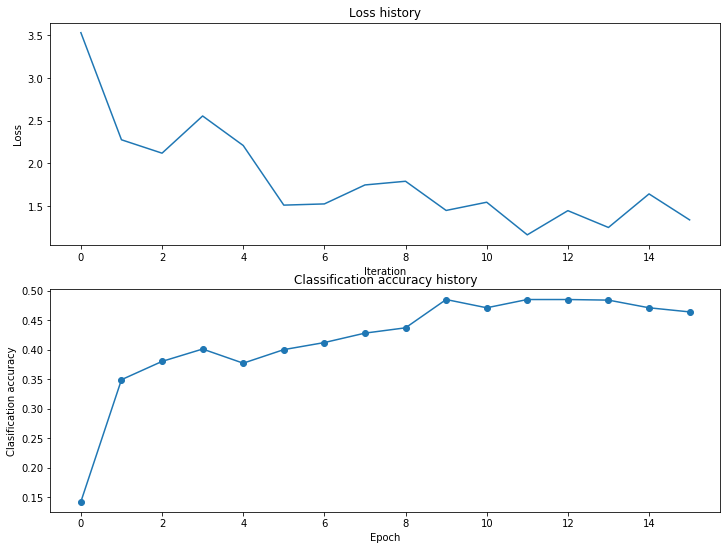

In [87]:
# 画图
plt.subplot(2, 1, 1)
plt.plot(x)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(y,'-o', label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### Module API: Train a Three-Layer ConvNet
现在应该使用模块API在CIFAR上训练一个三层的ConvNet。这应该看起来很像训练两层网络!您不需要调整任何超参数，但是经过一段时间的训练后，您应该可以达到45%以上。
你应该使用没有动量的随机梯度下降来训练模型。

In [71]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model=ThreeLayerConvNet(3,channel_1,channel_2,10)
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Epochs 0
Iteration 0, loss = 2.6763
Checking accuracy on validation set
Got 107 / 1000 correct (10.70)

Iteration 100, loss = 2.0228
Checking accuracy on validation set
Got 346 / 1000 correct (34.60)

Iteration 200, loss = 1.5413
Checking accuracy on validation set
Got 430 / 1000 correct (43.00)

Iteration 300, loss = 1.7005
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Iteration 400, loss = 1.4794
Checking accuracy on validation set
Got 457 / 1000 correct (45.70)

Iteration 500, loss = 1.3682
Checking accuracy on validation set
Got 466 / 1000 correct (46.60)

Iteration 600, loss = 1.4897
Checking accuracy on validation set
Got 475 / 1000 correct (47.50)

Iteration 700, loss = 1.4058
Checking accuracy on validation set
Got 489 / 1000 correct (48.90)



([2.6763367652893066,
  2.022784948348999,
  1.5413262844085693,
  1.700487732887268,
  1.4794301986694336,
  1.368176817893982,
  1.4897373914718628,
  1.4057869911193848],
 [0.107, 0.346, 0.43, 0.444, 0.457, 0.466, 0.475, 0.489])

# Part IV. PyTorch Sequential API

第三部分介绍了PyTorch模块API，它允许您定义任意可学习的层及其连接性。
对于像前馈层这样的简单模型，你仍然需要通过三个步骤:子类的`nn.Module`，在`__init__`,中将层分配给类属性，并在`forward()`中将每一层逐个调用。有没有更方便的方法?

幸运的是，PyTorch提供了一个名为 `nn.Sequential`，将上述步骤合并为一个。它没有“nn”那么灵活。，因为您不能指定比前馈堆栈更复杂的拓扑，但是它对于许多用例来说已经足够了。

### Sequential API: Two-Layer Network
让我们看看如何重写我们的两层完全连接网络的例子与 `nn.Sequential`，然后使用上面定义的训练循环来训练它。
同样，您不需要在这里调整任何超参数，但是在经过一段时间的训练后，您应该能够达到40%以上的准确率。

In [72]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Epochs 0
Iteration 0, loss = 2.3335
Checking accuracy on validation set
Got 136 / 1000 correct (13.60)

Iteration 100, loss = 1.5648
Checking accuracy on validation set
Got 397 / 1000 correct (39.70)

Iteration 200, loss = 1.6825
Checking accuracy on validation set
Got 424 / 1000 correct (42.40)

Iteration 300, loss = 1.8195
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Iteration 400, loss = 1.6557
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)

Iteration 500, loss = 1.8843
Checking accuracy on validation set
Got 422 / 1000 correct (42.20)

Iteration 600, loss = 1.9000
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)

Iteration 700, loss = 2.0394
Checking accuracy on validation set
Got 434 / 1000 correct (43.40)



([2.3334877490997314,
  1.5648093223571777,
  1.6825041770935059,
  1.8194698095321655,
  1.655714750289917,
  1.884252667427063,
  1.9000388383865356,
  2.0394318103790283],
 [0.136, 0.397, 0.424, 0.408, 0.421, 0.422, 0.401, 0.434])

### Sequential API: Three-Layer ConvNet
这里你应该用`nn.Sequential`。使用与第三部分相同的架构定义和训练一个三层卷积神经网络:
1. 带有32个5x5滤波器的卷积层(带偏置)，填充0为2
2. 线性整流函数（Rectified Linear Unit）
3. 卷积层(带偏置)有16个3x3滤波器，填充0为1
4. 线性整流函数（Rectified Linear Unit）
5. 全连接层(带偏见)计算10个类的分数

你应该使用上面定义的‘random_weight’函数初始化你的权重矩阵，你应该使用上面的‘zero_weight’函数初始化你的偏置向量。
你应该使用Nesterov momentum 0.9的随机梯度下降法来优化你的模型。
同样，您不需要调整任何超参数，但是经过一个阶段的训练后，您应该看到准确率超过55%。

In [73]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model=nn.Sequential(
    nn.Conv2d(3,channel_1,5,padding=2),
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_1,channel_2,3,padding=1),
    nn.ReLU(inplace=True),
    Flatten(),
    nn.Linear(channel_2*32*32,10)
)
# for i in (0,2,5):
#     w_shape=model[i].weight.data.shape
#     b_shape=model[i].bias.data.shape
#     model[i].weight.data=random_weight(w_shape)
#     model[i].bias.data=zero_weight(b_shape)

optimizer=optim.SGD(model.parameters(),nesterov=True,lr=learning_rate, momentum=0.9)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Epochs 0
Iteration 0, loss = 2.2992
Checking accuracy on validation set
Got 158 / 1000 correct (15.80)

Iteration 100, loss = 1.5176
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Iteration 200, loss = 1.4129
Checking accuracy on validation set
Got 481 / 1000 correct (48.10)

Iteration 300, loss = 1.4257
Checking accuracy on validation set
Got 521 / 1000 correct (52.10)

Iteration 400, loss = 1.3350
Checking accuracy on validation set
Got 523 / 1000 correct (52.30)

Iteration 500, loss = 1.3110
Checking accuracy on validation set
Got 529 / 1000 correct (52.90)

Iteration 600, loss = 1.0635
Checking accuracy on validation set
Got 572 / 1000 correct (57.20)

Iteration 700, loss = 1.3828
Checking accuracy on validation set
Got 571 / 1000 correct (57.10)



([2.299175500869751,
  1.5175790786743164,
  1.4128787517547607,
  1.4257279634475708,
  1.3349725008010864,
  1.3110129833221436,
  1.0635403394699097,
  1.382818579673767],
 [0.158, 0.444, 0.481, 0.521, 0.523, 0.529, 0.572, 0.571])

# Part V. CIFAR-10 open-ended challenge

在本节中，您可以在CIFAR-10上试验任何您想要的ConvNet架构。
现在，您的工作是对体系结构、超参数、损失函数和优化器进行试验，以训练在10个时间周期内在CIFAR-10 **验证**设置上达到**至少70%**精度的模型。您可以使用上面的check_accuracy和train函数。你可以使用任何一个“nn”。模块”或“神经网络。连续的API。
描述一下你在这本笔记本的结尾做了什么。
以下是每个组件的官方API文档。注意:我们在类“空间批处理规范”中称为PyTorch中的“BatchNorm2D”。

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **过滤器大小**:以上我们使用5x5;更小的过滤器会更有效吗?
- **过滤器的数量**:上面我们使用了32个过滤器。多做还是少做更好?
- **池与跨步卷积**:你使用最大池或只是跨步卷积?
- **批处理归一化**:尝试在卷积层之后添加空间批处理归一化，在仿射层之后添加普通批处理归一化。你的社交网络训练得更快吗?
- **网络结构**:上面的网络有两层可训练参数。你能用深层网络做得更好吗?好的架构包括:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **全局平均池**:不是变平，然后有多个仿射层，执行卷积，直到你的图像变得很小(7x7左右)，然后执行平均池操作，以得到一个1x1图像图像(1,1，过滤器#)，然后再重塑成一个(过滤器#)向量。这在[谷歌的Inception网络]中使用(https://arxiv.org/abs/1512.00567)(他们的架构见表1)。
- **正则化**:添加l2权重正则化，或者使用Dropout。

### Tips for training
对于您尝试的每个网络体系结构，您都应该调整学习率和其他超参数。当你这样做的时候，有几件重要的事情要记住:
- 如果参数工作良好，你应该看到改善在几百次迭代
- 记住超参数调优的由粗到细的方法:首先测试大范围的超参数，只需要几个训练迭代，就可以找到有效的参数组合。
- 一旦你找到了一些参数，似乎工作，搜索更精细围绕这些参数。你可能需要为更多的时代而训练。
- 您应该使用验证集进行超参数搜索，并保存您的测试集，以便根据验证集所选择的最佳参数来评估您的体系结构。

### Going above and beyond
如果您喜欢冒险，您可以实现许多其他特性来尝试和改进性能。您**不需要**实现任何这些，但如果您有时间，请不要错过其中的乐趣!
- 替代优化:你可以尝试Adam，Adagrad, RMSprop等。
- 可选的激活函数，如leaky ReLU、parameter ReLU、ELU或MaxOut。
- —模型集合体
- 数据增加
- 新架构
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [88]:
from torchsummary import summary
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.relu=nn.ReLU(inplace=True)
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             self.relu,
#             nn.MaxPool2d(kernel_size=2),

#             nn.Conv2d(64, 192, kernel_size=3, padding=1),
#             self.relu,
#             nn.MaxPool2d(kernel_size=2),

#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             self.relu,

#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             self.relu,

#             # nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             # nn.ReLU(inplace=True),
#             # nn.MaxPool2d(kernel_size=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x: Tensor = self.avgpool(x)
#         x = x.view(-1, 7 * 7 * 256)
#         x = self.classifier(x)
#         return x
VGG16=nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
     nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),

    Flatten(),
    nn.Dropout(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 10))
model=VGG16
optimizer=optim.Adam(model.parameters())

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
(losses,accs)=train_part34(model, optimizer, epochs=20)
summary(model, (3,32,32))

Epochs 0
Iteration 0, loss = 2.3003
Checking accuracy on validation set
Got 112 / 1000 correct (11.20)

Iteration 100, loss = 2.1527
Checking accuracy on validation set
Got 187 / 1000 correct (18.70)

Iteration 200, loss = 1.9137
Checking accuracy on validation set
Got 200 / 1000 correct (20.00)

Iteration 300, loss = 2.1134
Checking accuracy on validation set
Got 215 / 1000 correct (21.50)

Iteration 400, loss = 2.0464
Checking accuracy on validation set
Got 224 / 1000 correct (22.40)

Iteration 500, loss = 1.8254
Checking accuracy on validation set
Got 197 / 1000 correct (19.70)

Iteration 600, loss = 1.7882
Checking accuracy on validation set
Got 271 / 1000 correct (27.10)

Iteration 700, loss = 1.6435
Checking accuracy on validation set
Got 261 / 1000 correct (26.10)

Epochs 1
Iteration 0, loss = 1.6488
Checking accuracy on validation set
Got 310 / 1000 correct (31.00)

Iteration 100, loss = 1.7110
Checking accuracy on validation set
Got 368 / 1000 correct (36.80)

Iteration 200, l

Got 834 / 1000 correct (83.40)

Iteration 700, loss = 0.4394
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Epochs 10
Iteration 0, loss = 0.4729
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Iteration 100, loss = 0.7603
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Iteration 200, loss = 0.7365
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)

Iteration 300, loss = 0.4739
Checking accuracy on validation set
Got 808 / 1000 correct (80.80)

Iteration 400, loss = 0.5633
Checking accuracy on validation set
Got 801 / 1000 correct (80.10)

Iteration 500, loss = 0.2988
Checking accuracy on validation set
Got 835 / 1000 correct (83.50)

Iteration 600, loss = 0.3321
Checking accuracy on validation set
Got 805 / 1000 correct (80.50)

Iteration 700, loss = 0.4618
Checking accuracy on validation set
Got 826 / 1000 correct (82.60)

Epochs 11
Iteration 0, loss = 0.2905
Checking accuracy on validation set
Got 830 / 1000

Got 861 / 1000 correct (86.10)

Iteration 600, loss = 0.1569
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Iteration 700, loss = 0.0676
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
     

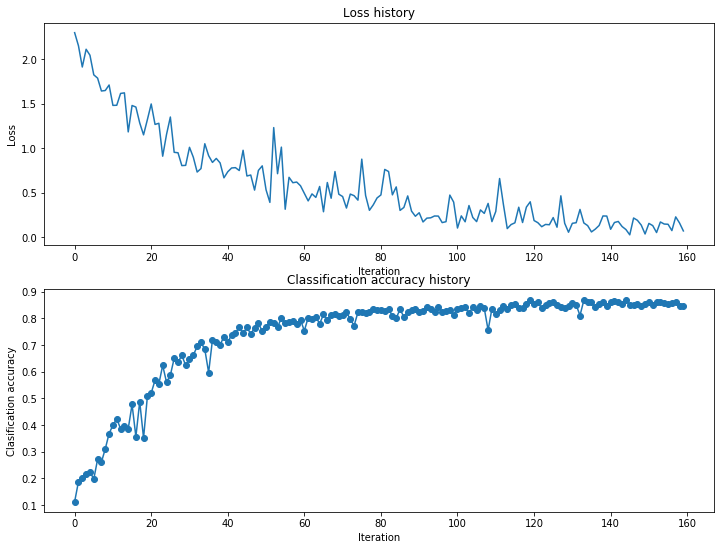

In [89]:
# 画图
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(accs,'-o', label='val')
plt.title('Classification accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Clasification accuracy')
plt.show()

## 描述你做了什么
在下面的单元格中，你应该解释你做了什么，你实现了什么额外的功能，和/或你在培训和评估你的网络的过程中做了什么。

TODO: Describe what you did

## 测试集——只运行一次
现在我们得到了满意的结果，我们在测试集上测试我们的最终模型(应该存储在best_model中)。考虑一下这与您的验证集精度相比如何。

In [34]:
best_model = model
check_accuracy_part34(loader_test, best_model)

Checking accuracy on test set
Got 8188 / 10000 correct (81.88)
